In [18]:
import torch
from torch import no_grad
import torchvision
from torchvision import transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests

The code snippet imports several crucial Python libraries that are commonly used in deep learning and computer vision tasks. The `torch` library, along with the `no_grad` context manager from PyTorch, is central to building and running neural networks efficiently, especially during inference where gradient calculations are not required, thus saving memory and computational power. The `torchvision` library extends PyTorch by providing datasets, model architectures, and image transformation tools, with the `transforms` module being particularly useful for preprocessing and augmenting image data.

Additionally, `cv2` from the OpenCV library plays a key role in computer vision by offering a wide range of functions for image processing, such as reading, resizing, and format conversion. `numpy`, accessed via the alias `np`, supports efficient numerical computations and operations on image data through its powerful array and matrix manipulation capabilities. The `PIL.Image` module from the Python Imaging Library (PIL), now maintained under the `Pillow` project, provides essential tools for opening, manipulating, and saving images in various formats.

For visualization, `matplotlib.pyplot`, imported as `plt`, allows the creation of plots and charts, and is particularly useful for displaying images and results from computer vision tasks. Lastly, the `requests` library facilitates making HTTP requests, enabling the easy download of images or other resources from the web by simply providing the URL. Collectively, these imports establish a robust environment for handling and visualizing images, building and deploying deep learning models, and performing a variety of computer vision tasks.

## Helper Function

In [19]:
# Function to get predictions with optional filtering by object and threshold
def get_predictions(pred, threshold=0.8, objects=None):
    """
    Assign a string name to predicted classes and filter out predictions below a given threshold.

    Args:
        pred: List containing tuples with class labels, probabilities, and bounding boxes.
        threshold: Minimum probability required to consider a prediction valid.
        objects: Optional list of object names to filter predictions.

    Returns:
        List of tuples containing class name, probability, and bounding box for each valid prediction.
    """
    predicted_classes = [(COCO_INSTANCE_CATEGORY_NAMES[i], p, [(box[0], box[1]), (box[2], box[3])])
                         for i, p, box in zip(list(pred[0]['labels'].numpy()),
                                              pred[0]['scores'].detach().numpy(),
                                              list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes = [stuff for stuff in predicted_classes if stuff[1] > threshold]

    if objects and predicted_classes:
        predicted_classes = [(name, p, box) for name, p, box in predicted_classes if name in objects]

    return predicted_classes

The function `get_predictions` is designed to process and filter predictions made by an object detection model. It takes in three parameters: `pred`, which is the raw output from the model containing information about the detected objects; `threshold`, a minimum probability value used to filter out predictions with low confidence; and `objects`, an optional list of object names to further filter the predictions based on specific classes.

The function first converts the raw predictions into a more readable format by creating a list of tuples. Each tuple contains the class name (translated from a numerical label using `COCO_INSTANCE_CATEGORY_NAMES`), the probability of the detection, and the bounding box coordinates that define where the object is located in the image. This conversion is done using a list comprehension that zips together the labels, scores, and bounding boxes from the model's output.

Next, the function filters out any predictions that do not meet the specified probability threshold, ensuring that only predictions with a confidence level higher than the threshold are retained. If the `objects` parameter is provided, the function further narrows down the predictions to include only those objects that match the specified names.

Finally, the function returns the filtered list of tuples, each containing a class name, probability, and bounding box coordinates for the valid predictions. This processed output can then be used for further analysis or visualization in object detection tasks.

In [20]:
# Function to draw bounding boxes around detected objects
def draw_box(predicted_classes, image, rect_th=1, text_size=1, text_th=1):
    """
    Draw bounding boxes and labels around detected objects in an image.

    Args:
        predicted_classes: List of tuples containing class name, probability, and bounding box.
        image: Image tensor on which boxes and labels will be drawn.
        rect_th: Thickness of the rectangle.
        text_size: Font size of the label text.
        text_th: Thickness of the label text.
    """
    img = (np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()
    for predicted_class in predicted_classes:
        label, probability, box = predicted_class
        t, l = box[0]
        r, b = box[1]
        t, l, r, b = [round(item) for item in [t, l, r, b]]
        cv2.rectangle(img, (t, l), (r, b), (0, 255, 0), rect_th)  # Draw Rectangle
        cv2.putText(img, f"{label}: {str(round(probability, 2))}", (t, l), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

The `draw_box` function is designed to visualize the results of an object detection model by drawing bounding boxes and labels around detected objects in an image. The function takes four parameters:

1. **`predicted_classes`**: A list of tuples, where each tuple contains the class name of the detected object, the probability or confidence score of the detection, and the coordinates of the bounding box around the object.
2. **`image`**: The image on which the bounding boxes and labels will be drawn. This image is expected to be a tensor (as commonly used in PyTorch).
3. **`rect_th`**: The thickness of the bounding box to be drawn around each detected object.
4. **`text_size`** and **`text_th`**: These parameters control the font size and thickness of the text labels that display the class name and probability on the image.

The function begins by converting the image tensor into a format that can be processed by OpenCV, a widely used computer vision library. It converts the tensor from its original format (typically used in deep learning) into a NumPy array that represents the image in the RGB color space, with values scaled between 0 and 255.

Next, the function iterates over the `predicted_classes` list. For each detected object, it extracts the class name, probability, and bounding box coordinates. The coordinates of the bounding box are rounded to the nearest integer, ensuring that they can be used accurately in drawing operations.

The bounding box is then drawn on the image using OpenCV’s `cv2.rectangle` function, which takes the top-left and bottom-right corners of the box, along with the color and thickness of the rectangle. The label, which includes the class name and probability, is added to the image at the top-left corner of the bounding box using `cv2.putText`.

Finally, the function converts the image back to the RGB format (if necessary) and displays it using Matplotlib’s `plt.imshow`, allowing the user to visualize the detected objects with their corresponding bounding boxes and labels. This function is essential for interpreting the results of object detection models and is particularly useful in applications like image annotation and automated object recognition.

In [21]:
# Function to clear GPU memory and delete images to free up RAM
def save_RAM(image_=False):
    """
    Clear GPU memory and delete image variables to free up RAM.
    
    Args:
        image_: Boolean flag to indicate if the image object should be deleted.
    """
    torch.cuda.empty_cache()
    global image, img, pred
    del img, pred
    if image_:
        image.close()
        del image

The `save_RAM` function is designed to manage and free up memory, particularly in environments where GPU memory is limited and needs to be carefully managed, such as during deep learning model inference. The function primarily focuses on clearing GPU memory and optionally deleting image variables from RAM.

Here's a breakdown of the function:

1. **`torch.cuda.empty_cache()`**: This PyTorch function is called to release all unoccupied cached memory held by the GPU. This doesn't free the actual allocated memory, but it clears the cache, making more memory available for new tensors or operations.

2. **Global Variables**: The function references the global variables `image`, `img`, and `pred`. These variables are expected to hold the image data and predictions that are typically used in object detection tasks. By using the `global` keyword, the function ensures that it is operating on the same variables that were used elsewhere in the script or notebook.

3. **`del img, pred`**: This line deletes the variables `img` and `pred` from memory. In Python, `del` is used to delete references to objects, which helps free up the memory those objects were occupying. This is especially important in GPU computing, where memory is a critical resource.

4. **Optional Image Deletion**: The function includes an optional parameter `image_`, which defaults to `False`. If set to `True`, the function will also delete the `image` variable after closing it. The `image.close()` method is called to properly release any resources associated with the image, such as file handles, before the image is deleted from memory using `del image`.

Overall, the `save_RAM` function is a practical utility for managing memory resources during intensive GPU-based computations, helping to prevent memory leaks and ensuring that memory is efficiently used throughout the execution of a program. This is particularly valuable in workflows involving large datasets or models, where memory management is crucial for maintaining performance and preventing crashes.

## Model Preparation

In [22]:
# Load Pre-Trained Faster RCNN Model
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()  # Set the model to evaluation mode

# Disable gradient computation for all parameters
for name, param in model_.named_parameters():
    param.requires_grad = False

print("Model loaded successfully.")

Model loaded successfully.


The code above is responsible for loading and preparing a pre-trained Faster R-CNN (Region-based Convolutional Neural Network) model with a ResNet-50 backbone and Feature Pyramid Network (FPN) for object detection tasks. Faster R-CNN is a widely used model architecture for object detection, capable of identifying and localizing objects within images by generating bounding boxes around them.

The model is loaded using the `torchvision.models.detection.fasterrcnn_resnet50_fpn()` function, with the `pretrained=True` argument indicating that the model weights should be initialized with a version pre-trained on a large dataset, typically the COCO dataset. This pre-training allows the model to have strong initial performance on object detection tasks, even with new data.

Once the model is loaded, it is set to evaluation mode using the `model_.eval()` method. This is crucial because it disables certain layers, such as dropout and batch normalization, that behave differently during training and inference. In evaluation mode, these layers function in a deterministic way, ensuring consistent and reliable predictions.

The code then iterates through all the model's parameters using the `model_.named_parameters()` function and sets `requires_grad = False` for each parameter. This step effectively freezes the model's weights, preventing any updates during the forward pass. This is important for inference, where the goal is to use the model as is, without modifying its learned parameters.

Finally, a confirmation message "Model loaded successfully." is printed, indicating that the model is ready for use in object detection tasks. This setup is typical when deploying a pre-trained model for inference, ensuring that it runs efficiently and accurately without any further training.

In [23]:
# Function to get predictions from the model
def model(x):
    with no_grad():
        yhat = model_(x)
    return yhat


The `model` function is a straightforward utility designed to generate predictions from a pre-trained object detection model in a memory-efficient manner. The function accepts an input `x`, which typically represents an image or a batch of images in tensor form, ready for inference. Inside the function, the `with no_grad()` context manager is used to temporarily disable gradient calculations during the forward pass. This is important because gradient computations are unnecessary during inference, and disabling them helps save memory and computational resources, making the process faster and more efficient.

Within this context, the model, represented by `model_`, is applied to the input `x`, producing the output `yhat`, which contains the model's predictions. These predictions might include object classifications, bounding box coordinates, and confidence scores, depending on the model's architecture. The function then returns `yhat`, providing the caller with the predictions without any additional overhead. This simple yet effective function is essential for using the pre-trained model to analyze new images, ensuring that predictions are made efficiently and accurately.

In [24]:
# COCO class names
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

The `COCO_INSTANCE_CATEGORY_NAMES` list defines the class names used in the COCO (Common Objects in Context) dataset, a large-scale dataset widely used for object detection tasks. This list includes common objects that the model can detect, such as "person," "car," "bicycle," "dog," and "airplane." Each entry corresponds to a specific category that the model might recognize in an image, with the first entry `__background__` representing areas with no object detected. The "N/A" entries indicate categories not applicable in certain contexts within the dataset. This list is essential for translating model predictions from numerical labels to human-readable class names.

## PREDICTION 

The code below will demonstrates how to use a pre-trained object detection model to predict and visualize objects in various images. For each scenario, an image is loaded, resized, and converted into a tensor. The model then predicts the objects in the image, filtering results based on specific thresholds or object classes.

1. **Predicting a Person**: The code loads an image of Ronaldo, resizes it, and uses the model to detect the person in the image. The result is displayed with a bounding box around the detected person.

2. **Predicting People**: Similarly, another image with multiple people is processed. The model identifies individuals in the image, and bounding boxes are drawn with a higher threshold for accuracy.

3. **Predicting Animals**: An image containing a cat and dog is analyzed, with the model detecting these animals. The bounding boxes and labels are drawn larger and thicker for visibility.

4. **Predicting a Car and a Plane**: An image with a car and a plane is used to demonstrate detection of multiple objects with the model, highlighting them with bounding boxes.

5. **Predicting on a Random Uploaded Image**: Finally, a random image from a URL is processed. The model detects objects in the image, and the results are displayed with adjusted bounding box and label sizes.

In each case, after the predictions are made and visualized, memory is cleared using the `save_RAM` function to efficiently manage resources.

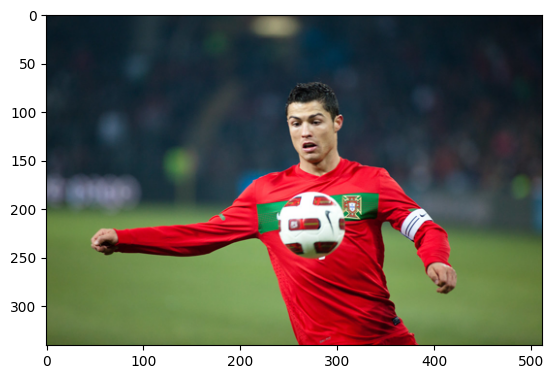

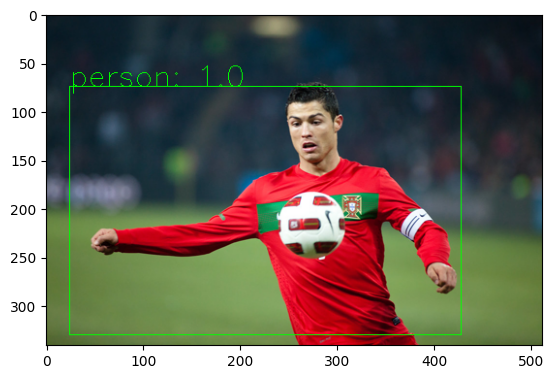

In [25]:
# 1. Predicting a Person
img_path = '/kaggle/input/sample-images-for-object-detection/ronaldo.jpg'
image = Image.open(img_path)
image = image.resize([int(0.5 * s) for s in image.size])
plt.imshow(image)
plt.show()

transform = transforms.Compose([transforms.ToTensor()])
img = transform(image)
pred = model([img])
pred_class = get_predictions(pred, objects=["person"])
draw_box(pred_class, img)
save_RAM(image_=True)

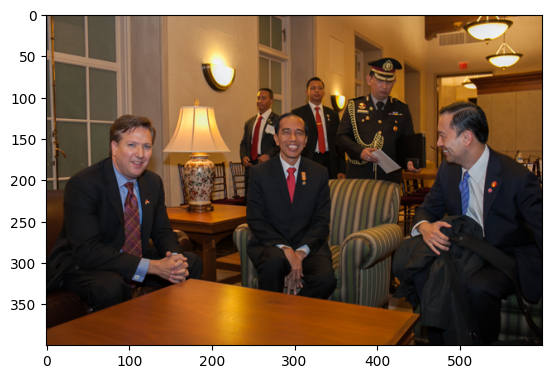

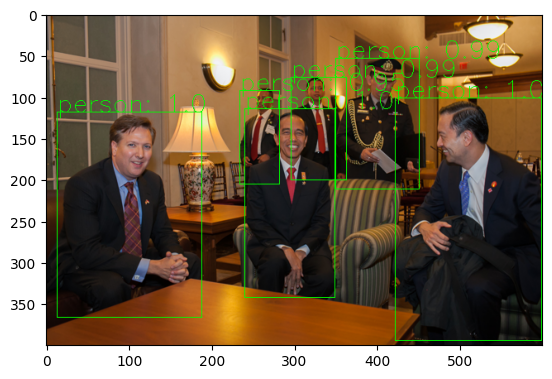

In [26]:
# 2. Predicting People
img_path = '/kaggle/input/sample-images-for-object-detection/people.jpg'
image = Image.open(img_path)
image = image.resize([int(0.5 * s) for s in image.size])
plt.imshow(image)
plt.show()

img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.9, objects=["person"])
draw_box(pred_thresh, img, rect_th=1, text_size=1, text_th=1)
save_RAM(image_=True)

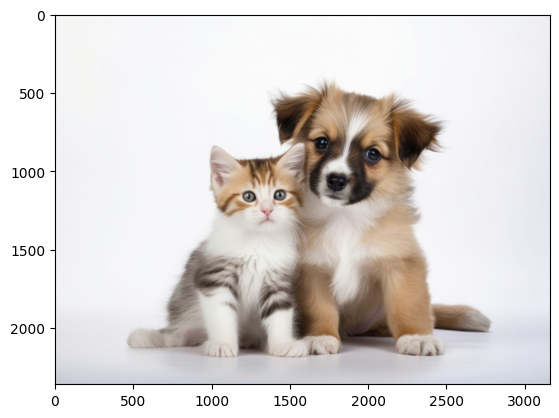

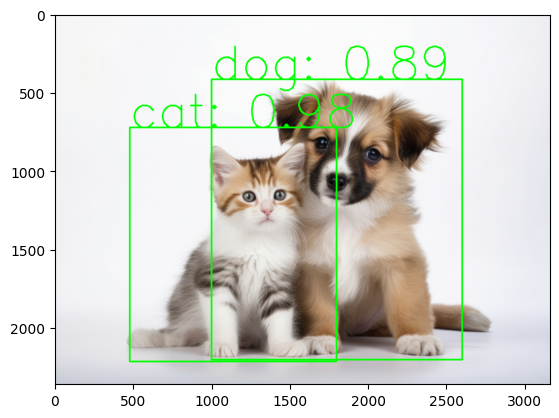

In [27]:

# 3. Predicting Cat and Dog
img_path = '/kaggle/input/sample-images-for-object-detection/catanddog.jpg'
image = Image.open(img_path)
image = image.resize([int(0.5 * s) for s in image.size])
plt.imshow(image)
plt.show()

img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.8)
draw_box(pred_thresh, img, rect_th=10, text_size=10, text_th=10)
save_RAM(image_=True)

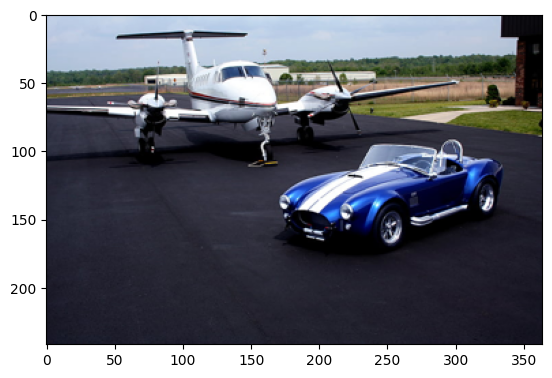

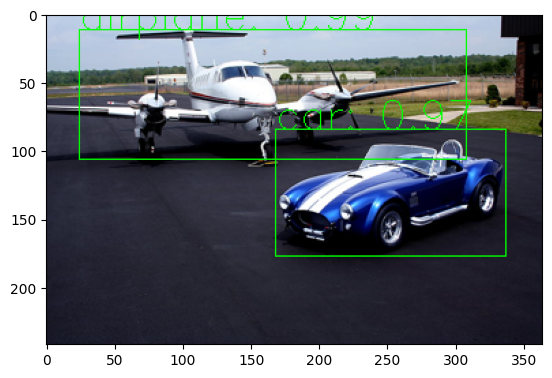

In [28]:
# 4. Predicting a Car and a Plane
img_path = '/kaggle/input/sample-images-for-object-detection/carandplane.jpg'
image = Image.open(img_path)
image = image.resize([int(0.5 * s) for s in image.size])
plt.imshow(image)
plt.show()

img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.9)
draw_box(pred_thresh, img)
save_RAM(image_=True)

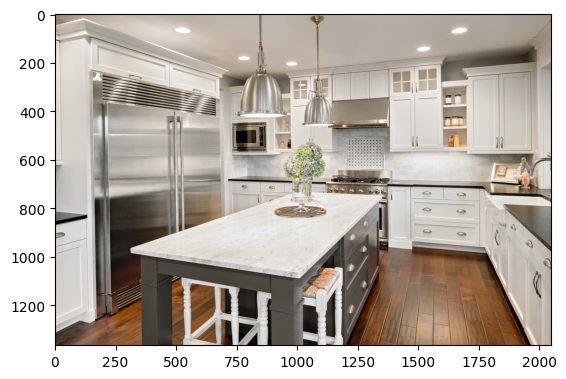

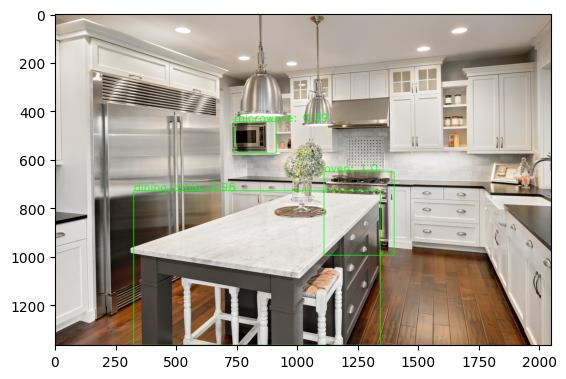

In [29]:
# 5. Predicting on a Random Uploaded Image
url = 'https://www.plastform.ca/wp-content/themes/plastform/images/slider-image-2.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
plt.imshow(image)
plt.show()

img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.95)
draw_box(pred_thresh, img, rect_th=2, text_size=1.5, text_th=2)
save_RAM(image_=True)

## Conclusion

The code provides a practical demonstration of how to use a pre-trained object detection model to detect and visualize various objects within images. By leveraging a Faster R-CNN model with a ResNet-50 backbone, the code efficiently processes images to identify objects such as people, animals, vehicles, and other common items. The process involves loading images, resizing them, transforming them into tensors, and using the model to predict objects, followed by drawing bounding boxes and labels for easy visualization. Memory management is also handled effectively to ensure smooth execution.

### Things to Research More

- **Faster R-CNN Model**: Understand how Faster R-CNN architecture works, especially how it combines region proposal networks with object detection.
- **ResNet-50 Backbone**: Explore the role of ResNet-50 as a feature extractor within the Faster R-CNN model.
- **Image Transformation in PyTorch**: Learn more about the image transformation process, especially how `transforms.Compose` and `transforms.ToTensor` work to prepare images for deep learning models.
- **Bounding Box Visualization**: Delve into how OpenCV is used to draw bounding boxes and labels on images, and explore different parameters to customize these visualizations.
- **Memory Management in PyTorch**: Research how `torch.cuda.empty_cache()` and proper deletion of variables can help manage GPU memory during model inference.
- **Threshold and Filtering in Object Detection**: Investigate how varying the confidence threshold affects the precision and recall of detected objects, and how object-specific filtering can be applied to focus on certain categories. 

These topics will deepen your understanding of how object detection models work and how to optimize them for specific tasks.